<a href="https://colab.research.google.com/github/nfsdns/Fokker-Plank-Equation/blob/main/Fokker_Planck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fokker-Planck

\begin{align}
      \frac{\partial u}{\partial t} = \left[-\frac{\partial }{\partial x}A(x)+\frac{\partial^2}{\partial x^2}B(x)\right]u
  \end{align}

\begin{align}
      u(x,0) = f(x)
  \end{align}



In [4]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

## Version 1

In [5]:
# -------------------------
# Define Problem Examples
# -------------------------

examples = {
    1: {"A": lambda x, u: -u, "B": lambda x, u: u, "u_exact": lambda x, t: x + t, "x0": lambda t: t, "x1": lambda t: t + 1, "f_x": lambda x: x},
    2: {"A": lambda x, u: x * u, "B": lambda x, u: (x**2 / 2.0) * u, "u_exact": lambda x, t: x * torch.exp(t), "x0": lambda t: 0, "x1": lambda t: torch.exp(t), "f_x": lambda x: x},
    3: {"A": lambda x, u: -(x + 1) * u, "B": lambda x, t, u: x**2 * torch.exp(t) * u, "u_exact": lambda x, t: (x + 1) * torch.exp(t), "x0": lambda t: torch.exp(t), "x1": lambda t: 2*torch.exp(t), "f_x": lambda x: x + 1}
}

In [6]:
# -------------------------
# Function to Compute Derivatives
# -------------------------
def derivative(u, inp):
    return torch.autograd.grad(u, inp, grad_outputs=torch.ones_like(u), create_graph=True)[0]

In [7]:
# -------------------------
# Define the Neural Network (Configurable)
# -------------------------
class PINN(nn.Module):
    def __init__(self, activation='tanh'):
        super().__init__()
        self.l1 = nn.Linear(2, 10)
        self.l2 = nn.Linear(10, 10)
        self.l3 = nn.Linear(10, 1)

        activations = {'tanh': nn.Tanh(), 'relu': nn.ReLU(), 'swish': nn.SiLU()}
        self.activation = activations.get(activation, nn.Tanh())

    def forward(self, x):
        x = self.activation(self.l1(x))
        x = self.activation(self.l2(x))
        x = self.l3(x)
        return x

In [8]:
# -------------------------
# Training
# -------------------------
def train_pinn(example_id, activation='tanh', lr=0.001, n_epochs=10000, tol=1e-6):
    example = examples[example_id]

    x = torch.linspace(0, 1, 11, requires_grad=True)
    t = torch.linspace(0, 1, 5, requires_grad=True)
    x, t = torch.meshgrid(x, t, indexing='ij')
    x, t = x.reshape(-1, 1), t.reshape(-1, 1)

    model = PINN(activation=activation)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

    prev_loss = float('inf')
    for i in range(n_epochs):
        x_t = torch.cat((x, t), 1)
        u = model(x_t)

        u_t = derivative(u, t)
        u_x = derivative(u, x)
        u_xx = derivative(u_x, x)

        AU = example['A'](x, t,u)
        AU_x = derivative(AU, x)
        BU = example['B'](x, t, u)
        BU_xx = derivative(derivative(BU, x), x)

        loss_residual = ((u_t + AU_x - BU_xx) ** 2).mean()

        t0 = torch.zeros_like(t)
        x_t0 = torch.cat((x, t0), 1)
        loss_initial = ((model(x_t0) - example['f_x'](x)) ** 2).mean()  #TODO:

        x0 = torch.zeros_like(x)
        x0_t = torch.cat((x0, t), 1)
        loss_b1 = ((model(x0_t) - example['x0'](t)) ** 2).mean() #TODO

        x1 = torch.ones_like(x)
        x1_t = torch.cat((x1, t), 1)
        loss_b2 = ((model(x1_t) - example['x1'](t)) ** 2).mean() #TODO

        loss_total = loss_residual + loss_initial + loss_b1 + loss_b2

        optimizer.zero_grad()
        loss_total.backward()
        optimizer.step()
        # scheduler.step(loss_total)

        # if abs(prev_loss - loss_total.item()) < tol:
        #     print(f'Early stopping at epoch {i}, Loss = {loss_total.item():.4e}')
        #     break
        # prev_loss = loss_total.item()

        # if i % 1000 == 0:
        #     print(f'Example {example_id} - Epoch {i}: Loss = {loss_total.item():.4e}')

    return model, x, t, example['u_exact'](x, t)


In [9]:
# -------------------------
# Run All Examples and Plot Results
# -------------------------
def plot_results(example_id, x, t, u_pred, u_exact):
    x = x.reshape(50, 10).detach().numpy()
    t = t.reshape(50, 10).detach().numpy()
    u_pred = u_pred.reshape(50, 10).detach().numpy()
    u_exact = u_exact.reshape(50, 10).detach().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': '3d'})
    axs[0].plot_surface(x, t, u_pred, cmap='viridis')
    axs[0].set_title(f'Example {example_id} - Predicted')
    axs[1].plot_surface(x, t, u_exact, cmap='viridis')
    axs[1].set_title(f'Example {example_id} - Exact')
    axs[2].plot_surface(x, t, np.abs(u_exact - u_pred), cmap='inferno')
    axs[2].set_title(f'Example {example_id} - Error')
    plt.show()

In [10]:
def compute_errors(u_exact, u_pred):
        m = u_exact.numel()
        error = u_exact - u_pred
        RMS = torch.sqrt(torch.sum(error ** 2) / m)
        Ne = torch.sqrt(torch.sum(error ** 2) / torch.sum(u_exact ** 2))
        MAE = torch.mean(torch.abs(error))
        return RMS.item(), Ne.item(), MAE.item()

In [11]:
# for example_id in examples.keys():
#     model, x, t, u_exact = train_pinn(example_id)
#     x_t = torch.cat((x, t), 1)
#     u_pred = model(x_t)

#     plot_results(example_id, x, t, u_pred, u_exact)
#     RMS_error, Ne_error, MAE_error = compute_errors(u_exact, u_pred)
#     print(f'Example {example_id} - Final RMS Error: {RMS_error:.4e}')
#     print(f'Example {example_id} - Final Ne Error: {Ne_error:.4e}')
#     print(f'Example {example_id} - Final MAE Error: {MAE_error:.4e}')


## Version 2

In [12]:
# -------------------------
# Define Problem Examples
# -------------------------

examples = {
    1: {"A": lambda x, u: -u, "B": lambda x, u: u, "u_exact": lambda x, t: x + t, "x0": lambda t: t, "x1": lambda t: t + 1, "f_x": lambda x: x},
    2: {"A": lambda x, u: x * u, "B": lambda x, u: (x**2 / 2.0) * u, "u_exact": lambda x, t: x * torch.exp(t), "x0": lambda t: 0, "x1": lambda t: torch.exp(t), "f_x": lambda x: x}
    # 3: {"A": lambda x, t, u: -(x + 1) * u, "B": lambda x, t, u: x**2 * torch.exp(t) * u, "u_exact": lambda x, t: (x + 1) * torch.exp(t), "x0": lambda t: torch.exp(t), "x1": lambda t: 2*torch.exp(t), "f_x": lambda x: x + 1}
}

In [13]:

# -------------------------
# Function to Compute Derivatives
# -------------------------
def derivative(u, inp):
    return torch.autograd.grad(u, inp, grad_outputs=torch.ones_like(u), create_graph=True)[0]


In [14]:
# -------------------------
# Define the Neural Network (Configurable)
# -------------------------
class PINN(nn.Module):
    def __init__(self, activation='tanh'):
        super().__init__()
        self.l1 = nn.Linear(2, 16)
        self.l2 = nn.Linear(16, 16)
        self.l3 = nn.Linear(16, 16)
        self.l4 = nn.Linear(16, 16)
        self.l5 = nn.Linear(16, 16)
        self.l6 = nn.Linear(16, 1)

        activations = {'tanh': nn.Tanh(), 'relu': nn.ReLU(), 'swish': nn.SiLU()}
        self.activation = activations.get(activation, nn.Tanh())

    def forward(self, x):
        x = self.activation(self.l1(x))
        x = self.activation(self.l2(x))
        x = self.activation(self.l3(x))
        x = self.activation(self.l4(x))
        x = self.activation(self.l5(x))
        x = self.l6(x)
        return x

In [15]:
# -------------------------
# Compute Loss Function
# -------------------------
def compute_loss(model, x, t, example_id):
    example = examples[example_id]
    x_t = torch.cat((x, t), 1)
    u = model(x_t)

    u_t = derivative(u, t)
    u_x = derivative(u, x)
    u_xx = derivative(u_x, x)

    if example_id == 3:
        AU = example['A'](x, t, u)
        BU = example['B'](x, t, u)

    else:
        AU = example['A'](x, u)
        BU = example['B'](x, u)

    AU_x = derivative(AU, x)
    BU_xx = derivative(derivative(BU, x), x)

    loss_residual = ((u_t + AU_x - BU_xx) ** 2).mean()

    t0 = torch.zeros_like(t)
    x_t0 = torch.cat((x, t0), 1)
    loss_initial = ((model(x_t0) - example['f_x'](x)) ** 2).mean()

    x0_t = torch.cat((torch.zeros_like(t), t), 1)
    loss_b1 = ((model(x0_t) - example['x0'](t)) ** 2).mean()

    x1_t = torch.cat((torch.ones_like(t), t), 1)
    loss_b2 = ((model(x1_t) - example['x1'](t)) ** 2).mean()

    return loss_residual + loss_initial + loss_b1 + loss_b2


In [16]:
# -------------------------
# Training Function
# -------------------------
def train_pinn(example_id, len_x, len_t, activation='tanh', lr=0.001, n_epochs=10000, tol=1e-6):
    example = examples[example_id]
    x = torch.linspace(0, 1, len_x, requires_grad=True)
    t = torch.linspace(0, 1, len_t, requires_grad=True)
    x, t = torch.meshgrid(x, t, indexing='ij')
    x, t = x.reshape(-1, 1), t.reshape(-1, 1)

    model = PINN(activation=activation)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    prev_loss = float('inf')

    for i in range(n_epochs):
        loss_total = compute_loss(model, x, t, example_id)
        optimizer.zero_grad()
        loss_total.backward()
        optimizer.step()
        # if abs(prev_loss - loss_total.item()) < tol:
        #     print(f'Early stopping at epoch {i}, Loss = {loss_total.item():.4e}')
        #     break
        # prev_loss = loss_total.item()

    # return model
    return model, x, t, example['u_exact'](x, t)

In [17]:
def compute_errors(u_exact, u_pred):
        m = u_exact.numel()
        error = u_exact - u_pred
        RMS = torch.sqrt(torch.sum(error ** 2) / m)
        Ne = torch.sqrt(torch.sum(error ** 2) / torch.sum(u_exact ** 2))
        MAE = torch.mean(torch.abs(error))
        return RMS.item(), Ne.item(), MAE.item()

In [18]:
# -------------------------
# Run All Examples and Plot Results
# -------------------------
def plot_results(example_id, x, t, u_pred, u_exact, len_x, len_t):
    x = x.reshape(len_x, len_t).detach().numpy()
    t = t.reshape(len_x, len_t).detach().numpy()
    u_pred = u_pred.reshape(len_x, len_t).detach().numpy()
    u_exact = u_exact.reshape(len_x, len_t).detach().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': '3d'})
    axs[0].plot_surface(x, t, u_pred, cmap='viridis')
    axs[0].set_title(f'Example {example_id} - Predicted')
    axs[1].plot_surface(x, t, u_exact, cmap='viridis')
    axs[1].set_title(f'Example {example_id} - Exact')
    axs[2].plot_surface(x, t, np.abs(u_exact - u_pred), cmap='inferno')
    axs[2].set_title(f'Example {example_id} - Error')
    plt.show()

In [19]:
# # -------------------------
# # Run All Examples and Plot Results
# # -------------------------
# def plot_results(example_id, x, t, u_pred, u_exact, len_x, len_t):
#     x = x.reshape(len_x, len_t).detach().numpy()
#     t = t.reshape(len_x, len_t).detach().numpy()
#     u_pred = u_pred.reshape(len_x, len_t).detach().numpy()
#     u_exact = u_exact.reshape(len_x, len_t).detach().numpy()

#     fig, axs = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': '3d'})

#     # Predicted Surface
#     axs[0].plot_surface(x, t, u_pred, cmap='viridis')
#     axs[0].set_title(f'Example {example_id} - Predicted')
#     axs[0].set_xlabel('x')
#     axs[0].set_ylabel('t')
#     axs[0].set_zlabel('u_pred')

#     # Exact Solution Surface
#     axs[1].plot_surface(x, t, u_exact, cmap='viridis')
#     axs[1].set_title(f'Example {example_id} - Exact')
#     axs[1].set_xlabel('x')
#     axs[1].set_ylabel('t')
#     axs[1].set_zlabel('u_exact')

#     # Error Surface
#     axs[2].plot_surface(x, t, np.abs(u_exact - u_pred), cmap='inferno')
#     axs[2].set_title(f'Example {example_id} - Error')
#     axs[2].set_xlabel('x')
#     axs[2].set_ylabel('t')
#     axs[2].set_zlabel('|u_exact - u_pred|')

#     plt.show()


In [20]:
# -------------------------
# Run Experiment with Optional Testing
# -------------------------
def run_experiment(example_id, len_x, len_t, activation='tanh', lr=0.001, n_epochs=10000):
    print(f"\nExample {example_id} ...")
    model, x, t, u_exact = train_pinn(example_id, len_x, len_t, activation, lr, n_epochs)
    x_t = torch.cat((x, t), 1)
    u_pred = model(x_t)
    plot_results(example_id, x, t, u_pred, u_exact, len_x, len_t)
    RMS_error, Ne_error, MAE_error = compute_errors(u_exact, u_pred)
    print(f'Example {example_id} - Final Ne Error: {Ne_error:.4e}')
    print(f'Example {example_id} - Final RMS Error: {RMS_error:.4e}')
    print(f'Example {example_id} - Final MAE Error: {MAE_error:.4e}')


Example 1 ...


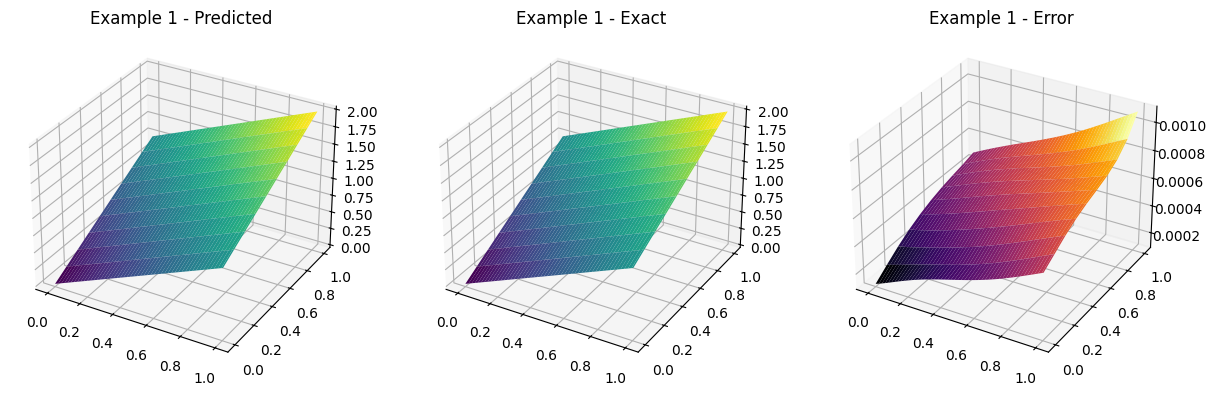

Example 1 - Final Ne Error: 5.3828e-04
Example 1 - Final RMS Error: 5.8642e-04
Example 1 - Final MAE Error: 5.5526e-04


In [21]:
run_experiment(1, 100, 10, 'swish', lr = 0.001)


Example 2 ...


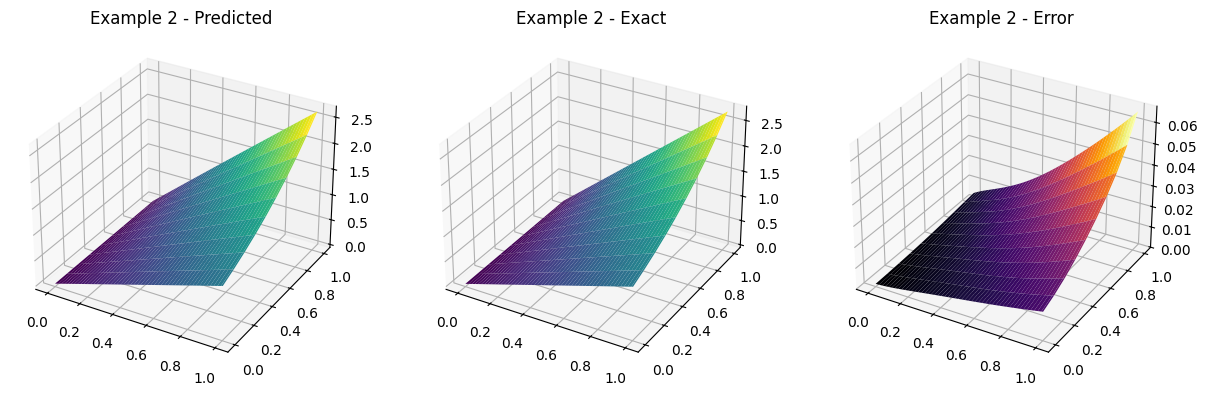

Example 2 - Final Ne Error: 1.9473e-02
Example 2 - Final RMS Error: 2.0495e-02
Example 2 - Final MAE Error: 1.6052e-02


In [22]:
run_experiment(2, 100, 10, 'swish', lr = 0.01)